In [1]:
import pandas as pd
import numpy as np
from numpy import vstack, mean, std
import h5py
import torch
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn import metrics 
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split 
from torch import Tensor, nn
from torch.nn import Linear, Sigmoid, Module, BCELoss 
import torch.nn.functional as F
from torch.optim import SGD
from preprocessing import preprocess
from get_symbol import get_symbol
from prediction_pipeline import *

/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load and prepare data

In [85]:
def load_data(expression_path, libraries, gr_truth_path): 
    norm = get_expression_data(expression_path)
    binary_matrix = get_binary_matrix(norm.index, libraries)
    gr_truth = get_gr_truth(norm.columns, gr_truth_path)
    list_inputs = prepare_data(norm, binary_matrix)
    return list_inputs, gr_truth

def get_expression_data(expression_path): 
    f = pd.read_csv(expression_path)
    f.index = f.iloc[:, 0] # Make ENSG genes as row indexing 
    f = f.iloc[:, 1:] # Remove first index column 
    # Normalize data 
    norm = preprocess(f)
    # Convert Ensembl number index to gene symbol
    norm = get_symbol(norm)
    return norm 

def get_binary_matrix(gene_expr, libraries):
    function_to_genes = {}
    set_genes = set()
    for lib in libraries: 
        f2g, genes = gene_set_dictionaries(lib)
        function_to_genes.update(f2g)
        set_genes = set_genes | set(genes)
    common_genes = list(set_genes & set(gene_expr))
    binary_matrix = gs_binary_matrix(function_to_genes, set_genes).loc[common_genes]
    return binary_matrix

def get_gr_truth(list_samples, gr_truth_path):
    gr_truth = pd.read_csv(gr_truth_path, sep='\t')
    gr_truth = gr_truth.iloc[10, 1:]
    idx = [ "_".join(i.split("_")[:2]) for i in gr_truth.index ]
    gr_truth.index = idx
    gr_truth = pd.DataFrame(gr_truth).loc[list_samples]
    test = [ 1.0 if res[-3:] == 'POS' else 0.0 for res in gr_truth.iloc[:, 0] ]
    gr_truth.iloc[:, 0] = test
    gr_truth.columns = ["Truth"]
    return gr_truth

def prepare_data(norm, binary_matrix):
    # load the dataset
    list_inputs = []
    common_genes = set(binary_matrix.index) & set(norm.index)
    bm = binary_matrix.loc[common_genes]
    bm_tens = torch.tensor(bm.T.values)
    for sample in norm.columns: 
        item = torch.mul(bm_tens, torch.tensor(norm.loc[common_genes, sample].values))
        list_inputs.append(np.array(item).astype(np.float32))
    return list_inputs

In [3]:
# load the data 
expression_path = 'GSE156063_swab_gene_counts.csv.gz'
libraries = ['GO_Biological_Process_2018', 'GO_Molecular_Function_2018', 'GO_Cellular_Component_2018']
gr_truth_path = "GSE156063_series_matrix.txt"
list_inputs, gr_truth = load_data(expression_path, libraries, gr_truth_path) 

# Fully-connected layer

In [86]:
class Net(nn.Module):
    def __init__(self, shape):
        super(Net, self).__init__()
        self.fc1 = Linear(shape[1], 1)
        self.fc2 = Linear(shape[0], 1)
        self.sigmoid = nn.Sigmoid()

    # x represents our data
    def forward(self, x):
        total = list()
        for i in range(len(x)): 
            item = torch.from_numpy(x[i])
            y = self.fc1(item) 
            total.append(y)
        total = torch.cat(total, 1)
        total = torch.transpose(total, 0, 1)
        z = self.fc2(total)
        z = self.sigmoid(z)
        return z

def evaluate_model(results, gr_truth): 
    ns_probs = [0 for _ in range(results.shape[0])]
    ns_auc = roc_auc_score(gr_truth, ns_probs)
    lr_auc = roc_auc_score(gr_truth, results.detach().numpy())
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Fully-connected layer: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(gr_truth, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(gr_truth, results.detach().numpy())
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Fully-connected layer')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [68]:
my_nn = Net(list_inputs[0].shape)
results = my_nn(list_inputs)

No Skill: ROC AUC=0.500
Fully-connected layer: ROC AUC=0.630


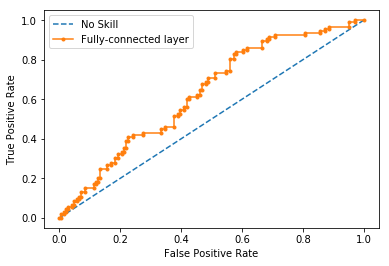

In [83]:
evaluate_model(results, gr_truth)